# Using the Normalizing Flow to generate embeddings

### Created by Jary Pomponi & Simone Scardapane

# Introduction

In this notebook we want to show how a Normalizing Flow (NF) can be used to lear a prior over the embeddings of an autoencoder, allowing fast sampling of real looking images.

A NF is a method that allows of constructing flexible posterior disstributions starting from a simpler one defined by a collection of continuous random variables. Given a vector $\mathbf{x}$, we want to express it as transformations $T(\cdot)$ from a real vector $\mathbf{u}$ sampled from a prior $p(\mathbf{u})$: 

$$\mathbf{x} = T(\mathbf{u})$$

The key property of the transformation $T(\cdot)$ is that it must be invertible and both, the transformation and its inverse, must be differentiable. Under these conditions, the $\mathbf{x}$ is well defined and can be obtained via the change of variables: 

$$p(\mathbf{x}) = p(\mathbf{u}) \vert detJ_T(\mathbf{u}) \vert^{-1} \, \, \text{with} \, \, \mathbf{u} = T^{-1}(\mathbf{x})$$

Another property of these transofrmations is that more transofrmation can be composed: 

$$ \mathbf{x} = T_k \circ T_{k-1} \dots T_1(\mathbf{u}) $$
$$ \mathbf{u} = (T_k \circ T_{k-1} \dots T_1)^{-1}(\mathbf{x}) = (T_0 \circ T_{1} \dots T_k)(\mathbf{x}) $$

and the jacobians are: 

$$ det J_{T_k \circ T_{k-1} \circ \dots  \circ T_1(\mathbf{u})} = det J_{T_k}(T_{k-1} \circ \dots  \circ T_1(\mathbf{u})) det J_{T_{k-1}}(T_{k-2} \circ \dots \circ T_1(\mathbf{u})) \cdots det J_{T_1}(\mathbf{u})   $$

Using these properties we can build a complex transofrmation which is a combination of simpliest one, leading to a more complex distribution $\mathbf{x}$.

In this notebook we use model proposed in [RealNVP](https://arxiv.org/abs/1605.08803). Each transformation is and affine ...

# Code

In [ ]:
import torch
from torch import nn
import rnvp
import numpy as np
from torchvision import datasets, transforms
import itertools
import matplotlib.pyplot as plt

## Hyper paramters

In [85]:
EMBEDDING_DIM = 20
FLOW_N = 7
RNVP_TOPOLOGY = [200]
AE_EPOCHS = 10
NF_EPOCHS = 20
SEED = 0
BATCH_SIZE = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Auto Enoder definition

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, stride=2, kernel_size=3, bias=False, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, stride=2, kernel_size=3, bias=False, padding=1)
        self.linear1 = nn.Linear(in_features=3136, out_features=EMBEDDING_DIM)
        
        self.linear2 = nn.Linear(in_features=EMBEDDING_DIM, out_features=3136)
        self.convt1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, stride=2, kernel_size=3, padding=1, output_padding=1)
        self.convt2 = nn.ConvTranspose2d(in_channels=32, out_channels=1, stride=2, kernel_size=3, padding=1, output_padding=1)


    def forward(self, x):
        
        emb = self.encoder(x)
        _x = self.decoder(emb)
        
        return _x, emb
    
    def decoder(self, emb):

        _x = torch.relu(self.linear2(emb))
        _x = _x.view(-1, 64, 7, 7)
        _x = torch.relu(self.convt1(_x))
        _x = self.convt2(_x)
        
        return _x
    
    def encoder(self, x):
        _x = torch.relu(self.conv1(x))
        _x = torch.relu(self.conv2(_x))
        sh = _x.shape

        _x = torch.relu(torch.flatten(_x, 1))
        
        emb = self.linear1(_x)
        
        return emb

### AutoEncoder training on MNIST

In [4]:
train_set = datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))
train_loader = torch.utils.data.DataLoader(train_set, BATCH_SIZE)

In [5]:
torch.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

loss_f = nn.BCELoss()

autoencoder = AutoEncoder()
autoencoder = autoencoder.to(device)

optimizer = torch.optim.Adam(itertools.chain(autoencoder.parameters()),
                             lr=1e-3, weight_decay=1e-5)

beta = 1
alpha = 1

for i in range(AE_EPOCHS):
    print('Epoch #{}'.format(i+1))

    losses = []
    for batch_idx, data in enumerate(train_loader):

        x, y = data
        y = y.to(device)
        y = torch.nn.functional.one_hot(y, 10).to(device).float()

        x = x.to(device)

        _x, emb = autoencoder(x)

        _x = torch.sigmoid(_x)

        rec_loss = loss_f(_x, x)

        loss = rec_loss

        autoencoder.zero_grad()
        loss.backward()
        optimizer.step()

### Creating a new dataset containing the embeddings and the associated label

In [12]:
embs = []

for batch_idx, data in enumerate(train_loader):

    with torch.no_grad():
        x, y = data

        x = x.to(device)

        _, emb = autoencoder(x)
        for i in range(len(emb)):
            embs.append((emb[i], y[i]))

In [8]:
embs_loader = torch.utils.data.DataLoader(embs, BATCH_SIZE)

### Normalizing Flow training

In [ ]:
nf_model = rnvp.LinearRNVP(input_dim=EMBEDDING_DIM, coupling_topology=RNVP_TOPOLOGY, flow_n=FLOW_N, batch_norm=True,
                      mask_type='odds', conditioning_size=10, use_permutation=True, single_function=True)

nf_model = nf_model.to(device)

optimizer1 = torch.optim.Adam(itertools.chain(nf_model.parameters()), lr=1e-4, weight_decay=1e-5)

nf_model.train()
for i in range(NF_EPOCHS):
    print('Epoch #{}'.format(i+1))

    losses = []
    for batch_idx, data in enumerate(embs_loader):

        emb, y = data
        emb = emb.to(device)
        y = y.to(device)
        y = torch.nn.functional.one_hot(y, 10).to(device).float()
        
        u, log_det = nf_model.forward(emb, y=y) 

        prior_logprob = nf_model.logprob(u)
        log_prob = -torch.mean(prior_logprob.sum(1) + log_det)

        loss = log_prob

        nf_model.zero_grad()

        loss.backward()

        optimizer1.step()

### Evalauting the NF

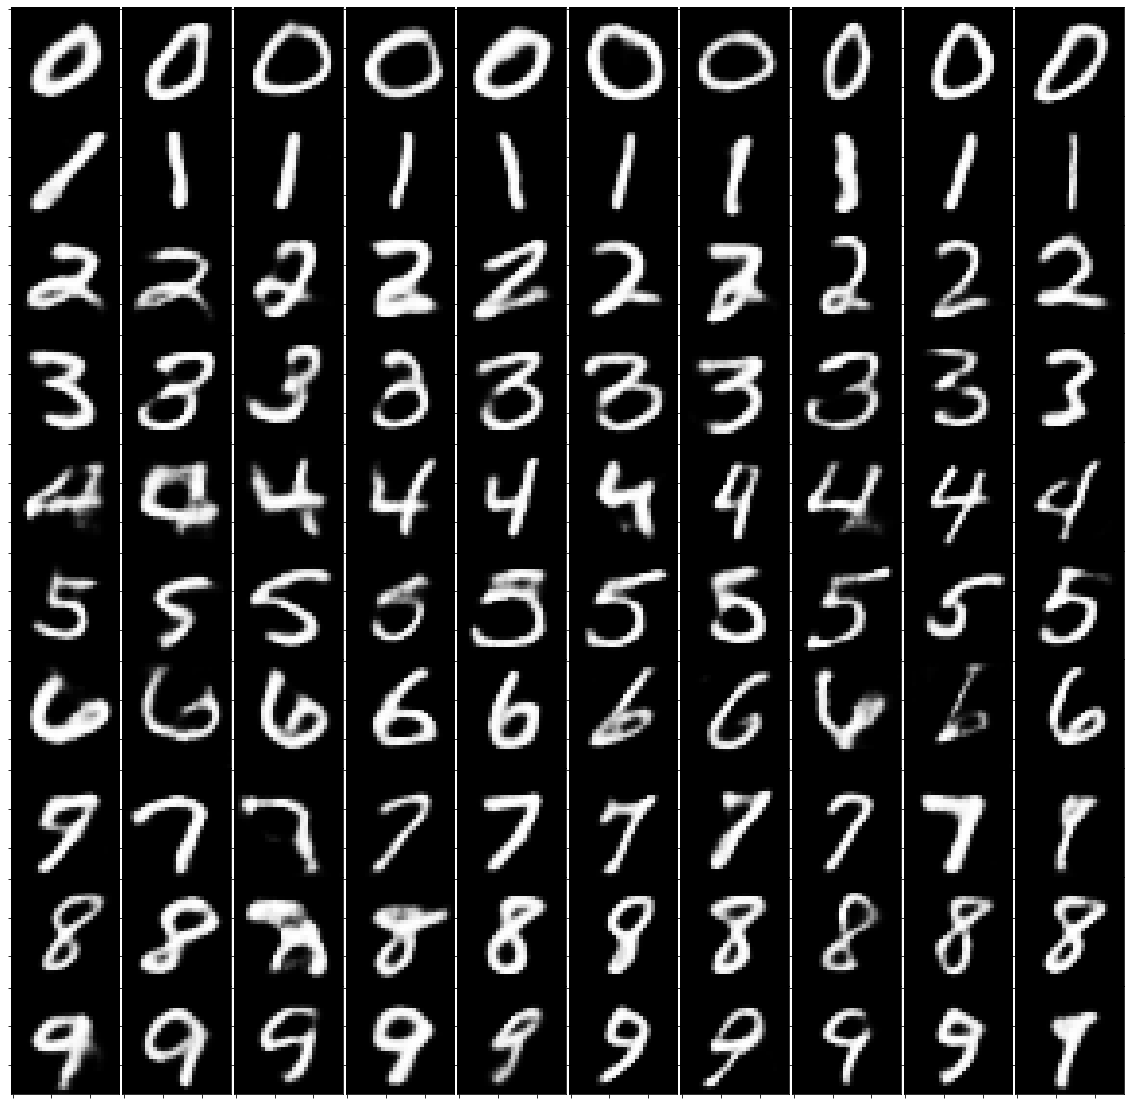

In [89]:
sample_n = 10
f, axs = plt.subplots(nrows=10, ncols=sample_n, figsize=(20, 20))

nf_model.eval()
with torch.no_grad():
    for j in range(10):

        y = torch.nn.functional.one_hot(torch.tensor([j]*sample_n), 10).to(device).float()
        emb, d = nf_model.sample(sample_n, y=y, return_logdet=True)
        z = autoencoder.decoder(emb)
        d_sorted = d.sort(0)[1].flip(0)
        z = z[d_sorted]
        z = torch.sigmoid(z).cpu()
        
        for i in range(sample_n):
            axs[j][i].imshow(z[i].reshape(28, 28), cmap='gray')

for ax in axs:
    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.set_aspect('equal')

f.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.close('all')